# Decision trees with a toy task and the UCI Adult dataset

In [122]:
import collections
from io import StringIO

import numpy as np
import pandas as pd
import pydotplus  # pip install pydotplus
import seaborn as sns
from ipywidgets import Image
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)

## Part 1. Toy dataset “Will They? Won’t They?”

### Creating the dataset

In [123]:
# creating a dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out


# some feature values will be present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [124]:
features = ["Looks", "Alcoholic_beverage", "Eloquence", "Money_spent"]

### Training data

In [125]:
df_train = {}
df_train["Looks"] = [
    "handsome",
    "handsome",
    "handsome",
    "repulsive",
    "repulsive",
    "repulsive",
    "handsome",
]
df_train["Alcoholic_beverage"] = ["yes", "yes", "no", "no", "yes", "yes", "yes"]
df_train["Eloquence"] = ["high", "low", "average", "average", "low", "high", "average"]
df_train["Money_spent"] = ["lots", "little", "lots", "little", "lots", "lots", "lots"]
df_train["Will_go"] = LabelEncoder().fit_transform(["+", "-", "+", "-", "-", "+", "+"])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


### Test data

In [126]:
df_test = {}
df_test["Looks"] = ["handsome", "handsome", "repulsive"]
df_test["Alcoholic_beverage"] = ["no", "yes", "yes"]
df_test["Eloquence"] = ["average", "high", "average"]
df_test["Money_spent"] = ["lots", "little", "lots"]
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [127]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train["Will_go"]
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train
feature_names = df_train.columns

### Train a decision tree using sklearn on the training data. You may choose any depth for the tree.

In [128]:
tree_1 = DecisionTreeClassifier(criterion = "entropy", max_depth=5, random_state=17)
tree_1.fit(df_train, y)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=17)

### Additional: display the resulting tree using graphviz. 

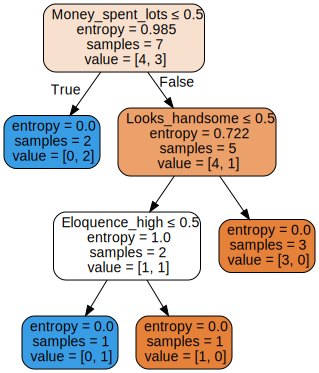

In [129]:
from sklearn import tree

dot_data = tree.export_graphviz(tree_1, 
                  feature_names=feature_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                           )
graph = graphviz.Source(dot_data)
graph

## Part 2. Functions for calculating entropy and information gain.

In [130]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

In [131]:
# two groups
balls_left = [1 for i in range(8)] + [0 for i in range(5)]  # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)]  # 1 blue and 6 yellow

In [132]:
def entropy(a_list):
    """Calculates and returns the Shannon entropy of the list a_list"""
    total = len(a_list)
    categories = collections.Counter(a_list)
    entropy = 0
    for cat in categories:
        occurence = categories[cat]
        pb = occurence / total
        entropy -= pb*np.log2(pb)
    return entropy

In [133]:
# The entropy of the state given by the list balls_left
entropy(balls_left)

0.9612366047228759

In [134]:
# The entropy of a fair dice
entropy(range(1,7))

2.584962500721156

In [135]:
def information_gain(root, left, right):
    """Calculates the information gain of a certain split where
    root - initial data, left and right - two partitions of initial data"""
    S0 = entropy(root); S1 = entropy(left); S2 = entropy(right)
    total_elem = len(root)
    n_left = len(left) 
    n_right = total_elem - n_left
    IG = S0 - (n_left*S1 + n_right*S2)/total_elem
    return IG


In [136]:
# The information gain from splitting the initial dataset into balls_left and balls_right
information_gain(balls, balls_left, balls_right)

0.16088518841412436

In [137]:
def information_gains(X, y):
    """Outputs information gain when splitting with each feature"""
    out = []
    for i in X.columns:
        out.append(information_gain(y, y[X[i]==0], y[X[i] == 1]))
    return out


In [138]:
def btree(X, y, feature_names):
    clf = information_gains(X, y)
    best_feat_id = clf.index(max(clf))
    best_feature = feature_names[best_feat_id]
    print(f"Best feature to split: {best_feature}")

    x_left = X[X.iloc[:, best_feat_id] == 0]
    x_right = X[X.iloc[:, best_feat_id] == 1]
    print(f"Samples: {len(x_left)} (left) and {len(x_right)} (right)")

    y_left = y[X.iloc[:, best_feat_id] == 0]
    y_right = y[X.iloc[:, best_feat_id] == 1]
    entropy_left = entropy(y_left)
    entropy_right = entropy(y_right)
    print(f"Entropy: {entropy_left} (left) and {entropy_right} (right)")
    print("_" * 30 + "\n")
    if entropy_left != 0:
        print(f"Splitting the left group with {len(x_left)} samples:")
        btree(x_left, y_left, feature_names)
    if entropy_right != 0:
        print(f"Splitting the right group with {len(x_right)} samples:")
        btree(x_right, y_right, feature_names)

In [139]:
btree(df_train, y, df_train.columns)


Best feature to split: Money_spent_little
Samples: 5 (left) and 2 (right)
Entropy: 0.7219280948873623 (left) and 0.0 (right)
______________________________

Splitting the left group with 5 samples:
Best feature to split: Looks_repulsive
Samples: 3 (left) and 2 (right)
Entropy: 0.0 (left) and 1.0 (right)
______________________________

Splitting the right group with 2 samples:
Best feature to split: Eloquence_high
Samples: 1 (left) and 1 (right)
Entropy: 0.0 (left) and 0.0 (right)
______________________________



## Part 3. The “Adult” dataset

### Reading train and test data

In [140]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [141]:
data_train = pd.read_csv(DATA_PATH + "adult_train.csv", sep=";")

In [142]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [143]:
data_test = pd.read_csv(DATA_PATH + "adult_test.csv", sep=";")

In [144]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [147]:
# we remove the rows with incorrect labels 
data_test = data_test[
    (data_test["Target"]==" >50K.") | (data_test["Target"]==" <=50K.")
]


Empty DataFrame
Columns: [Age, Workclass, fnlwgt, Education, Education_Num, Martial_Status, Occupation, Relationship, Race, Sex, Capital_Gain, Capital_Loss, Hours_per_week, Country, Target]
Index: []
